# DQN Agent for MineRLObtainDiamondShovel-v0 with Wood collection Task


In [ ]:
import os
import gym
import minerl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
from stable_baselines3.common.vec_env import SubprocVecEnv
import random
import time
from tqdm.notebook import tqdm
import gc

### Replay Memory

In [59]:
# set seeds for reproducability
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Environment Setup
os.environ['DISPLAY'] = ':0'
os.environ['MALMO_MINECRAFT_OUTPUT_LOG'] = 'true'
os.environ['MALMO_MINECRAFT_INITIAL_MEMORY'] = '2G'
os.environ['MALMO_MINECRAFT_MAX_MEMORY'] = '4G'
os.environ['MINERL_HEADLESS'] = '1'         # Training my model with GPU compute acceleration but CPU-based rendering
os.environ['MINERL_DISABLE_HUB'] = '1'
os.environ['MALMO_MINECRAFT_JVM_ARGS'] = '-XX:+UseG1GC -XX:MaxGCPauseMillis=50'


# Experience replay memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

### Custom Wrapper for environment

In [60]:
class LogOnlyWrapper(gym.Wrapper):
    def __init__(self, env, action_repeat = 4):
        super().__init__(env)
        self.logs_collected = 0
        self.action_repeat = action_repeat
    
    def reset(self):
        self.logs_collected = 0
        return super().reset()
    
    def step(self, action):
        # Repeat the action for multiple frames to speed up training
        total_reward = 0
        done = False
        info = None
        
        for _ in range(self.action_repeat):
            obs, reward, done, info = super().step(action)
            total_reward += reward
            
            # Check if logs were collected in this step
            logs_current = self._get_log_count(obs)
            logs_collected_step = max(0, logs_current - self.logs_collected)
            self.logs_collected = logs_current
            
            # If logs were collected, give reward and terminate
            if logs_collected_step > 0:
                total_reward = 1.0  # Fixed reward for collecting logs
                done = True
                break
                
            # Break early if done
            if done:
                break
        
        return obs, total_reward, done, info
    
    def _get_log_count(self, obs):
        # In MineRL, inventory is typically accessed through obs['inventory']
        if 'inventory' in obs:
            return obs['inventory'].get('log', 0)
        return 0


### Window Resize

In [61]:
class ResizeObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, size=(64, 64)):
        super().__init__(env)
        self.size = size
        
        import cv2
        self.cv2 = cv2
        
    def observation(self, observation):
        if isinstance(observation, dict) and 'pov' in observation:
            
            original_pov = observation['pov']
            resized_pov = self.cv2.resize(
                original_pov, 
                (self.size[1], self.size[0]),  # OpenCV expects (width, height)
                interpolation=self.cv2.INTER_AREA
            )
            observation['pov'] = resized_pov
        
        return observation

### Defining CNN model for processing image observations

In [62]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # Calculate the size of the output from conv layers
        conv_out_size = self._get_conv_output(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.zeros(batch_size, *shape)
        output = self.conv(input)
        return int(np.prod(output.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

### Preprocessing function for observations

In [63]:
def preprocess_observation(observation):
    # Extract the POV (camera view) from the observation
    if isinstance(observation, dict) and 'pov' in observation:
        pov = observation['pov']
        # Normalize and transpose for PyTorch (C, H, W)
        pov = np.transpose(pov, (2, 0, 1))
        pov = pov.astype(np.float32) / 255.0
        return pov
    else:
        raise ValueError("Expected observation to contain 'pov' key")

### Action selection with epsilon-greedy strategy

In [64]:
# Always Attack Wrapper for simplified action space
class AlwaysAttackWrapper(gym.ActionWrapper):
    def __init__(self, env, angle=10):
        super().__init__(env)
        # Define action dictionary with attack=True for all actions (basically attack on steroids)
        self.action_dict = {
            0: {'attack': 1, 'back': 0, 'camera': [0, 0], 'forward': 1, 'jump': 0, 'left': 0, 'right': 0,
                'sneak': 0, 'sprint': 0},  # Forward + attack
            1: {'attack': 1, 'back': 0, 'camera': [0, angle], 'forward': 0, 'jump': 0, 'left': 0,
                'right': 0, 'sneak': 0, 'sprint': 0},  # Look down + attack
            2: {'attack': 1, 'back': 0, 'camera': [0, -angle], 'forward': 0, 'jump': 0, 'left': 0,
                'right': 0, 'sneak': 0, 'sprint': 0},  # Look up + attack
            3: {'attack': 1, 'back': 0, 'camera': [angle, 0], 'forward': 0, 'jump': 0, 'left': 0,
                'right': 0, 'sneak': 0, 'sprint': 0},  # Look right + attack
            4: {'attack': 1, 'back': 0, 'camera': [-angle, 0], 'forward': 0, 'jump': 0, 'left': 0,
                'right': 0, 'sneak': 0, 'sprint': 0},  # Look left + attack
            5: {'attack': 1, 'back': 0, 'camera': [0, 0], 'forward': 1, 'jump': 1, 'left': 0, 'right': 0,
                'sneak': 0, 'sprint': 0},  # Jump forward + attack
            6: {'attack': 1, 'back': 0, 'camera': [0, 0], 'forward': 1, 'jump': 0, 'left': 0, 'right': 0,
                'sneak': 0, 'sprint': 0},  # Just forward (no attack)
            7: {'attack': 1, 'back': 0, 'camera': [0, 0], 'forward': 0, 'jump': 0, 'left': 0, 'right': 0,
                'sneak': 0, 'sprint': 0},  # No-op
        }
        # Create a discrete action space
        self.action_space = gym.spaces.Discrete(len(self.action_dict))
    
    def action(self, action_idx):
        # Convert the discrete action to the actual environment action
        return self.action_dict[action_idx]


In [65]:
# Action selection with epsilon-greedy strategy for simplified action space
def select_action(state, policy_net, action_space, epsilon, device):
    if random.random() < epsilon:
        return random.randint(0, action_space - 1)  
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.max(1)[1].item()

### Training Function

In [66]:
def optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma, device):
    if len(memory) < batch_size:
        return 0.0  # Not enough samples yet
    
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    # Create a mask of non-final states
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device, dtype=torch.bool)
    
    non_final_next_states = torch.tensor([s for s in batch.next_state if s is not None], 
                                         device=device, dtype=torch.float32)
    
    state_batch = torch.tensor(batch.state, device=device, dtype=torch.float32)
    action_batch = torch.tensor(batch.action, device=device, dtype=torch.long)
    reward_batch = torch.tensor(batch.reward, device=device, dtype=torch.float32)
    
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
    
    # Compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values
    expected_state_action_values = reward_batch + (gamma * next_state_values)
    
    # Compute loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Clip gradients to avoid exploding gradients
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss.item()

Official

In [67]:
def train_dqn_demo(env_name, total_timesteps, batch_size, gamma,
              eps_start, eps_end, eps_decay,
              target_update_freq, learning_rate, memory_size,
              eval_freq, log_freq, start_timestep, policy_net, target_net):
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # setting a watchdog 
    watchdog_timeout = 180 # three minutes
    
    # Create a regular environment first to get observation/action shapes
    env = gym.make(env_name)
    env = ResizeObservationWrapper(env, size=(64, 64))
    env = LogOnlyWrapper(env)
    env = AlwaysAttackWrapper(env, angle=10)
    observation = env.reset()
    pov = preprocess_observation(observation)
    input_shape = pov.shape
    n_actions =  env.action_space.n # Number of discrete actions we've defined
    
    print(f"Observation shape: {input_shape}, Action space size: {n_actions}")
    
    # Initialize networks
    if policy_net is None:
        policy_net = DQN(input_shape, n_actions).to(device)
    if target_net is None:
        target_net = DQN(input_shape, n_actions).to(device)
        target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    # Setup optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    
    # Setup replay memory
    memory = ReplayMemory(memory_size)
    
    # Training metrics
    episode_durations = []
    episode_rewards = []
    episode_losses = []
    episode_count = 0
    
    # Metrics for current episode
    current_episode_reward = 0
    current_episode_loss = 0
    current_episode_steps = 0
    
    # Adjust epsilon based on starting timestep
    if start_timestep > 0:
        epsilon = eps_end + (eps_start - eps_end) * np.exp(-start_timestep / (total_timesteps * 0.5))
    else:
        epsilon = eps_start 
    
    # Start training
    print("Starting training...")
    start_time = time.time()
    
    
    
    state = pov  # Use the preprocessed observation from earlier
    
    # Progress bar for timesteps
    progress_bar = tqdm(total=total_timesteps, initial=start_timestep)
    
    # Training loop
    timestep = 0
    done = False
    
    os.makedirs("checkpoint_minerl", exist_ok=True)

    timestep = start_timestep
    last_action_time = time.time()
    while timestep < total_timesteps:
        # Check if watchdog timer has expired
        current_time = time.time()
        if current_time - last_action_time > watchdog_timeout:
            print("\nWatchdog timer expired - environment appears stuck. Resetting...")
            try:
                env.close()
            except:
                pass
                
            # Kill Minecraft processes
            os.system("pkill -f Minecraft")
            os.system("pkill -f java")
            time.sleep(5)
            
            # Recreate environment
            env = gym.make(env_name)
            env = ResizeObservationWrapper(env, size=(64, 64))
            env = LogOnlyWrapper(env)
            env = AlwaysAttackWrapper(env, angle=10)
            
            # Reset state
            observation = env.reset()
            state = preprocess_observation(observation)
            current_episode_reward = 0
            current_episode_loss = 0
            current_episode_steps = 0
            done = False
            
            # Reset watchdog
            last_action_time = time.time()
            continue
        
        # Select action
        action_idx = select_action(state, policy_net, n_actions, epsilon, device)
        
        
        # Take step in environment
        observation, reward, done, _ = env.step(action_idx)
        
        # Process reward
        current_episode_reward += reward
        
        # Process next state (or set to None if episode is done)
        next_state = None if done else preprocess_observation(observation)
        
        # Store transition in replay memory
        memory.push(state, action_idx, next_state, reward, done)
        
        # Move to the next state
        state = next_state
        
        # Optimize model
        loss = optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma, device)
        if loss:
            current_episode_loss += loss
        
        # Update timestep and episode step count
        timestep += 1
        current_episode_steps += 1
        progress_bar.update(1)
        
        # Update the last action time for watchdog
        last_action_time = time.time()
        
        # Update target network based on timesteps
        if timestep % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print("Target network updated!")
        
        # Decay epsilon based on timesteps
        epsilon = eps_end + (eps_start - eps_end) * np.exp(-timestep / (total_timesteps * 0.5))
        
        # Log progress periodically
        if timestep % log_freq == 0:
            avg_reward = np.mean(episode_rewards[-10:]) if episode_rewards else 0
            avg_duration = np.mean(episode_durations[-10:]) if episode_durations else 0
            avg_loss = np.mean(episode_losses[-10:]) if episode_losses else 0
            
            current_time = time.time()
            elapsed = current_time - start_time
            
            print(f"\nTimestep: {timestep}/{total_timesteps} ({(timestep/total_timesteps)*100:.1f}%) | "
                  f"Episodes: {episode_count} | "
                  f"Epsilon: {epsilon:.4f} | "
                  f"Avg Reward: {avg_reward:.4f} | "
                  f"Avg Duration: {avg_duration:.1f} steps | "
                  f"Avg Loss: {avg_loss:.6f} | "
                  f"Elapsed: {elapsed:.1f}s")
        
        # Evaluate model periodically
        if timestep % eval_freq == 0 and timestep > 0:
            print("\nEvaluating model...")
            # Save checkpoint
            save_checkpoint = {
                'timestep': timestep,
                'policy_net': policy_net.state_dict(),
                'target_net': target_net.state_dict(),
                'epsilon': epsilon,
                'learning_rate': optimizer.param_groups[0]['lr'],
                'episode_durations' : episode_durations,
                'episode_rewards' : episode_rewards,
                'episode_losses' : episode_losses,
                'total_episodes' : episode_count
            }
            # Save checkpoint
            checkpoint_path = f"checkpoint_mineRL/dqn_minerl_checkpoint_{timestep}.pt"
            torch.save(save_checkpoint, checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")
        
        # Check if episode is done or if we've reached the max episode length
        if done or current_episode_steps >= 1000:  # Limit episode length
            # Record episode metrics
            episode_count += 1
            episode_durations.append(current_episode_steps)
            episode_rewards.append(current_episode_reward)
            
            # Calculate average loss for the episode
            if current_episode_steps > 0:
                episode_losses.append(current_episode_loss / current_episode_steps)
            else:
                episode_losses.append(0)
            
            # Reset environment for next episode
            observation = env.reset()
            state = preprocess_observation(observation)
            
            # Reset episode metrics
            current_episode_reward = 0
            current_episode_loss = 0
            current_episode_steps = 0
            done = False
            
            if episode_count % 2 == 0:
                try:
                    env.close()
                    # Small delay to ensure process termination
                    time.sleep(2)
                    # Kill any lingering processes
                    os.system("pkill -f Minecraft")
                    # Recreate environment
                    env = gym.make(env_name)
                    env = ResizeObservationWrapper(env, size=(64, 64))
                    env = LogOnlyWrapper(env)
                    env = AlwaysAttackWrapper(env, angle=10)
                except Exception as e:
                    print(f"Error during environment reset: {e}")
            
            observation = env.reset()
        
        if timestep % 500 == 0:
            gc.collect()
        
    # Training complete
    progress_bar.close()
    env.close()
    end_time = time.time()
    print(f"\nTraining complete! Time elapsed: {end_time - start_time:.2f} seconds")
    print(f"Total episodes completed: {episode_count}")
    
    # Save the final model
    # Save the final model
    final_checkpoint = {
                'timestep': timestep,
                'policy_net': policy_net.state_dict(),
                'target_net': target_net.state_dict(),
                'epsilon': epsilon,
                'learning_rate': optimizer.param_groups[0]['lr'],
                'episode_durations' : episode_durations,
                'episode_rewards' : episode_rewards,
                'episode_losses' : episode_losses,
                'total_episodes' : episode_count
            }
    model_path = "checkpoint_mineRL/dqn_minerl_log_finder.pt"
    torch.save(final_checkpoint, model_path)
    print(f"Final model saved to {model_path}")
    
    # Return training metrics and the trained model
    return {
        'policy_net': policy_net,
        'target_net': target_net,
        'episode_durations': episode_durations,
        'episode_rewards': episode_rewards,
        'episode_losses': episode_losses,
        'total_episodes': episode_count,
        'total_timesteps': timestep
    }

### RUN 

In [22]:
# Configuration
ENV_NAME = "MineRLObtainDiamondShovel-v0"
TOTAL_TIMESTEPS = 250_000  # Reduced for faster completion


# Train the model
training_metrics = train_dqn_demo(
    env_name=ENV_NAME,
    total_timesteps=TOTAL_TIMESTEPS,
    batch_size=64,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.9998,
    target_update_freq=2500,
    learning_rate=0.0001,
    memory_size=25000,
    eval_freq = 1000,
    log_freq = 1000,
    start_timestep=0,
    policy_net=None,
    target_net=None
)



Using device: cuda


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Observation shape: (3, 64, 64), Action space size: 8
Starting training...


  0%|          | 0/250000 [00:00<?, ?it/s]


Timestep: 1000/250000 (0.4%) | Episodes: 0 | Epsilon: 0.9924 | Avg Reward: 0.0000 | Avg Duration: 0.0 steps | Avg Loss: 0.000000 | Elapsed: 267.5s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_1000.pt

Timestep: 2000/250000 (0.8%) | Episodes: 1 | Epsilon: 0.9849 | Avg Reward: 0.0000 | Avg Duration: 1000.0 steps | Avg Loss: 0.000006 | Elapsed: 555.6s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_2000.pt


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Target network updated!

Timestep: 3000/250000 (1.2%) | Episodes: 2 | Epsilon: 0.9775 | Avg Reward: 0.0000 | Avg Duration: 1000.0 steps | Avg Loss: 0.000003 | Elapsed: 858.7s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_3000.pt

Timestep: 4000/250000 (1.6%) | Episodes: 3 | Epsilon: 0.9701 | Avg Reward: 0.0000 | Avg Duration: 1000.0 steps | Avg Loss: 0.000002 | Elapsed: 1150.6s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_4000.pt


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Target network updated!

Timestep: 5000/250000 (2.0%) | Episodes: 4 | Epsilon: 0.9627 | Avg Reward: 1.0000 | Avg Duration: 1000.0 steps | Avg Loss: 0.000043 | Elapsed: 1468.5s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_5000.pt

Timestep: 6000/250000 (2.4%) | Episodes: 5 | Epsilon: 0.9555 | Avg Reward: 0.8000 | Avg Duration: 1000.0 steps | Avg Loss: 0.000161 | Elapsed: 1736.9s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_6000.pt


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))



Timestep: 7000/250000 (2.8%) | Episodes: 6 | Epsilon: 0.9483 | Avg Reward: 0.6667 | Avg Duration: 1000.0 steps | Avg Loss: 0.000318 | Elapsed: 2055.2s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_7000.pt
Target network updated!

Timestep: 8000/250000 (3.2%) | Episodes: 7 | Epsilon: 0.9411 | Avg Reward: 0.5714 | Avg Duration: 1000.0 steps | Avg Loss: 0.000304 | Elapsed: 2334.6s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_8000.pt


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))



Timestep: 9000/250000 (3.6%) | Episodes: 8 | Epsilon: 0.9340 | Avg Reward: 0.5000 | Avg Duration: 1000.0 steps | Avg Loss: 0.000368 | Elapsed: 2645.5s

Evaluating model...
Checkpoint saved to checkpoint_mineRL/dqn_minerl_checkpoint_9000.pt


Failed to take a step (error timed out). Terminating episode and sending random observation, be aware. To account for this failure case in your code check to see if `'error' in info` where info is the info dictionary returned by the step function.
Traceback (most recent call last):
  File "/home/pateltirth2001/.local/lib/python3.10/site-packages/minerl/env/_multiagent.py", line 298, in step
    obs = comms.recv_message(instance.client_socket)
  File "/home/pateltirth2001/.local/lib/python3.10/site-packages/minerl/env/comms.py", line 63, in recv_message
    lengthbuf = recvall(sock, 4)
  File "/home/pateltirth2001/.local/lib/python3.10/site-packages/minerl/env/comms.py", line 73, in recvall
    newbuf = sock.recv(count)
TimeoutError: timed out



: 

### Plotting Routine

In [41]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    data = np.array(data)
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [42]:
def plot_training_metrics(metrics):
    plt.figure(figsize=(15, 12))
    
    # Plot reward
    plt.subplot(3, 1, 1)
    plt.plot(metrics['episode_rewards'], label = 'episode_rewards')
    plt.plot(moving_average(metrics['episode_rewards']), label = 'moving_average')
    plt.title('Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()
    
    # Plot episode duration
    plt.subplot(3, 1, 2)
    plt.plot(metrics['episode_durations'], label = 'episode_durations')
    plt.plot(moving_average(metrics['episode_durations']), label = 'moving_average')
    plt.title('Episode Duration')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.grid()
    plt.legend()
    
    # Plot loss
    plt.subplot(3, 1, 3)
    plt.plot(metrics['episode_losses'], label = 'episode_losses')
    plt.plot(moving_average(metrics['episode_losses']), label = 'moving_average')
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics_250k.png')
    plt.show()


### Evaluation Routine

In [68]:
# Function to evaluate the trained model
def evaluate_model(model, env_name, num_episodes=10, render=False, angle=10):
    # Create environment
    env = gym.make(env_name)
    env = ResizeObservationWrapper(env, size=(64, 64))
    env = LogOnlyWrapper(env)
    env = AlwaysAttackWrapper(env, angle=angle)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Metrics
    episode_rewards = []
    episode_durations = []
    success_rate = 0
    
    for episode in range(num_episodes):
        observation = env.reset()
        state = preprocess_observation(observation)
        
        total_reward = 0
        step_count = 0
        done = False
        
        while not done:
            if render:
                env.render()
                time.sleep(0.05)  # Slow down rendering
            
            # Select action (no exploration during evaluation)
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = model(state_tensor)
                action_idx = q_values.max(1)[1].item()
            
            # Take action
            observation, reward, done, _ = env.step(action_idx)
            
            # Update metrics
            total_reward += reward
            step_count += 1
            
            # Move to next state
            if not done:
                state = preprocess_observation(observation)
            
            # Limit episode length
            if step_count >= 1000: 
                break
        
        # Record metrics
        episode_rewards.append(total_reward)
        episode_durations.append(step_count)
        
        # Record success (whether a log was found)
        if total_reward > 0:
            success_rate += 1
        
        print(f"Evaluation Episode {episode+1}/{num_episodes} | Reward: {total_reward:.2f} | Steps: {step_count}")
    
    # Calculate final metrics
    avg_reward = np.mean(episode_rewards)
    avg_duration = np.mean(episode_durations)
    success_percentage = (success_rate / num_episodes) * 100
    
    print(f"\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Episode Duration: {avg_duration:.2f} steps")
    print(f"Success Rate: {success_percentage:.2f}%")
    
    return {
        'avg_reward': avg_reward,
        'avg_duration': avg_duration,
        'success_rate': success_percentage,
        'episode_rewards': episode_rewards,
        'episode_durations': episode_durations
    }


Loading checkpoint metrics

In [54]:
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    
    
    policy_net = checkpoint['policy_net'],
    target_net = checkpoint['target_net'], 
    episode_durations = checkpoint['episode_durations'],
    episode_rewards = checkpoint['episode_rewards'],
    episode_losses = checkpoint['episode_losses' ],
    total_episodes = checkpoint['total_episodes' ],
    
    
    metrics = {
        'policy_net' : policy_net,
        'target_net' : target_net,
        'episode_durations' : episode_durations[0],
        'episode_rewards' : episode_rewards[0],
        'episode_losses' : episode_losses[0],
        'total_episodes' : total_episodes
    }
    
    return metrics
    


In [55]:
path = "checkpoint_minerl/dqn_minerl_checkpoint_9000.pt"
metrics = load_checkpoint(path)


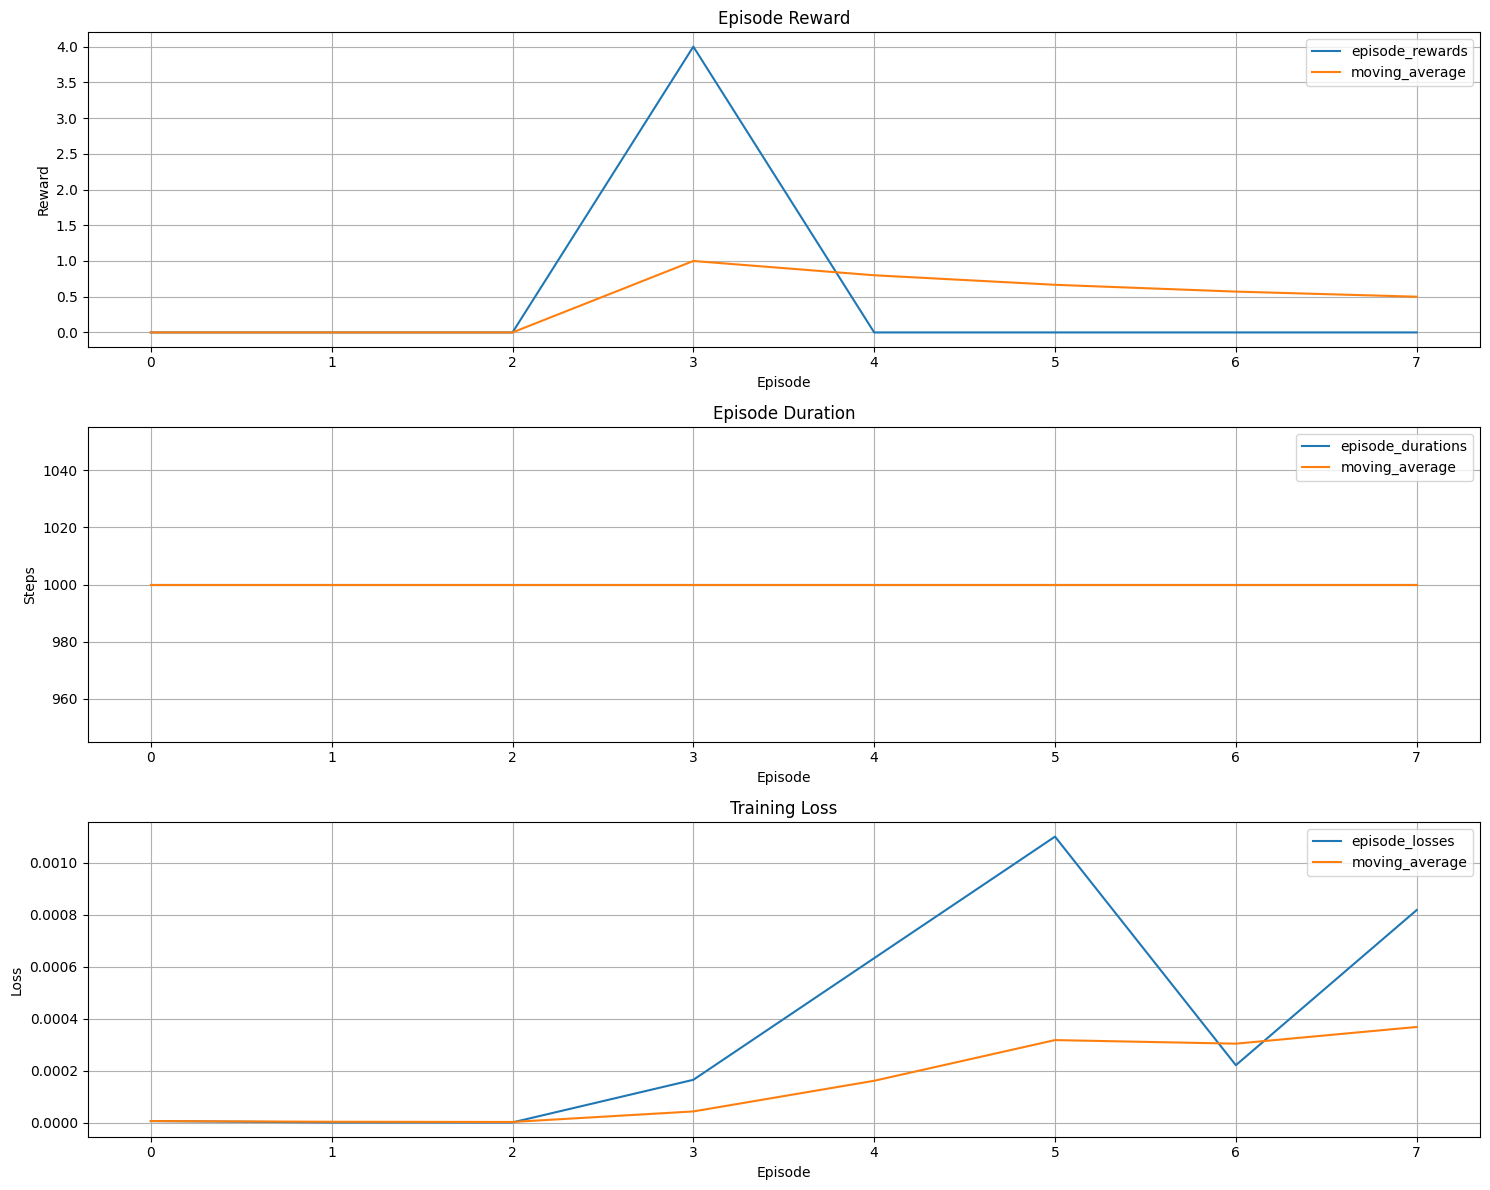

In [57]:
plot_training_metrics(metrics)

### Plot Evaluation Metrics

In [ ]:
def plot_evaluation_metrics(metrics):
    plt.figure(figsize=(15, 12))
    
    # Plot reward
    plt.subplot(2, 1, 1)
    plt.plot(metrics['episode_rewards'], label = 'episode_rewards')
    plt.plot(moving_average(metrics['episode_rewards']), label = 'moving_average')
    plt.title('Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()
    
    # Plot episode duration
    plt.subplot(2, 1, 2)
    plt.plot(metrics['episode_durations'], label = 'episode_durations')
    plt.plot(moving_average(metrics['episode_durations']), label = 'moving_average')
    plt.title('Episode Duration')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.grid()
    plt.legend()
    
    
    plt.tight_layout()
    plt.savefig('evaluation_metrics_250k.png')
    plt.show()

### Rendering Routine

In [48]:
def render_model(model_path, env_name, num_episodes=3):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    env = None  # Initialize to None so we can check if it exists in finally block
    
    try:
        # Create environment to get input shape
        env = gym.make(env_name)
        env = ResizeObservationWrapper(env, size=(64, 64))
        env = LogOnlyWrapper(env)
        env = AlwaysAttackWrapper(env, angle=10)
        
        observation = env.reset()
        pov = preprocess_observation(observation)
        input_shape = pov.shape
        n_actions = 8
        
        # Create and load model
        model = DQN(input_shape, n_actions).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        # Evaluate with rendering
        print("Rendering model predictions...")
        
        # Custom evaluation loop to ensure proper cleanup
        for episode in range(num_episodes):
            observation = env.reset()
            state = preprocess_observation(observation)
            
            total_reward = 0
            step_count = 0
            done = False
            
            while not done:
                try:
                    # Render the environment
                    env.render()
                    time.sleep(0.05)  # Slow down rendering
                    
                    # Select action (no exploration during evaluation)
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        q_values = model(state_tensor)
                        action_idx = q_values.max(1)[1].item()
                    
                    # Take action
                    observation, reward, done, _ = env.step(action_idx)
                    
                    # Update metrics
                    total_reward += reward
                    step_count += 1
                    
                    # Move to next state
                    if not done:
                        state = preprocess_observation(observation)
                    
                    # Limit episode length
                    if step_count >= 1000:
                        break
                        
                except KeyboardInterrupt:
                    print("\nRendering interrupted by user.")
                    return
                except Exception as e:
                    print(f"Error during rendering: {e}")
                    return
            
            print(f"Episode {episode+1}: Reward = {total_reward}, Steps = {step_count}")
            
    except KeyboardInterrupt:
        print("\nRendering interrupted by user.")
    except Exception as e:
        print(f"Error during initialization: {e}")
    finally:
        # Always clean up the environment
        if env is not None:
            try:
                print("Closing environment...")
                env.close()
                
                # Additional cleanup to ensure Java processes are terminated
                import os
                import signal
                import subprocess
                
                # Try to find and kill Minecraft/Java processes
                try:
                    processes = subprocess.check_output(["pgrep", "-f", "Minecraft"])
                    for pid in processes.splitlines():
                        try:
                            os.kill(int(pid), signal.SIGTERM)
                            print(f"Terminated Minecraft process: {pid}")
                        except:
                            pass
                except:
                    pass
                
                print("Environment closed successfully.")
            except Exception as cleanup_error:
                print(f"Error during cleanup: {cleanup_error}")


### Rendering with Video recording

In [ ]:
def render_model_video(model_path, env_name, num_episodes=3, record=True, output_path="minecraft_recording.mp4"):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    env = None  # Initialize to None so we can check if it exists in finally block
    video_writer = None
    
    try:
        # Create environment to get input shape
        env = gym.make(env_name)
        env = ResizeObservationWrapper(env, size=(64, 64))
        env = LogOnlyWrapper(env)
        env = AlwaysAttackWrapper(env, angle=10)
        
        observation = env.reset()
        pov = preprocess_observation(observation)
        input_shape = pov.shape
        n_actions = 8
        
        # Create and load model
        model = DQN(input_shape, n_actions).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        # Set up video recording if enabled
        if record:
            import cv2
            
            # Get the first frame to determine dimensions
            env.render(mode='rgb_array')  # This returns the rendered frame
            frame = env.render(mode='rgb_array')
            
            # Set up video writer - use mp4v codec
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            fps = 20  # 20 frames per second
            frame_size = (frame.shape[1], frame.shape[0])  # Width, height
            video_writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
            
            print(f"Recording video to {output_path}")
        
        # Evaluate with rendering
        print("Rendering model predictions...")
        
        # Custom evaluation loop to ensure proper cleanup
        for episode in range(num_episodes):
            observation = env.reset()
            state = preprocess_observation(observation)
            
            total_reward = 0
            step_count = 0
            done = False
            
            while not done:
                try:
                    # Render the environment
                    if record:
                        # Get frame from render
                        frame = env.render(mode='rgb_array')
                        # Convert from RGB to BGR (OpenCV uses BGR)
                        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                        # Write frame to video
                        video_writer.write(frame)
                    else:
                        env.render()
                    
                    time.sleep(0.05)  # Slow down rendering
                    
                    # Select action (no exploration during evaluation)
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        q_values = model(state_tensor)
                        action_idx = q_values.max(1)[1].item()
                    
                    # Take action
                    observation, reward, done, _ = env.step(action_idx)
                    
                    # Update metrics
                    total_reward += reward
                    step_count += 1
                    
                    # Move to next state
                    if not done:
                        state = preprocess_observation(observation)
                    
                    # Limit episode length
                    if step_count >= 1000:
                        break
                        
                except KeyboardInterrupt:
                    print("\nRendering interrupted by user.")
                    return
                except Exception as e:
                    print(f"Error during rendering: {e}")
                    return
            
            print(f"Episode {episode+1}: Reward = {total_reward}, Steps = {step_count}")
            
    except KeyboardInterrupt:
        print("\nRendering interrupted by user.")
    except Exception as e:
        print(f"Error during initialization: {e}")
    finally:
        # Clean up recording resources
        if video_writer is not None:
            video_writer.release()
            print(f"Video saved to {output_path}")
            
        # Always clean up the environment
        if env is not None:
            try:
                print("Closing environment...")
                env.close()
                
                # Additional cleanup to ensure Java processes are terminated
                import os
                import signal
                import subprocess
                
                # Try to find and kill Minecraft/Java processes
                try:
                    processes = subprocess.check_output(["pgrep", "-f", "Minecraft"])
                    for pid in processes.splitlines():
                        try:
                            os.kill(int(pid), signal.SIGTERM)
                            print(f"Terminated Minecraft process: {pid}")
                        except:
                            pass
                except:
                    pass
                
                print("Environment closed successfully.")
            except Exception as cleanup_error:
                print(f"Error during cleanup: {cleanup_error}")

### Plot Training Metrics

In [ ]:
# Plot training metrics
plot_training_metrics(training_metrics)

### Evaluate the Model

In [44]:
# Evaluate the model
policy_net = training_metrics['policy_net']
eval_metrics = evaluate_model(policy_net, ENV_NAME, num_episodes=5)

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Evaluation Episode 1/5 | Reward: 0.00 | Steps: 1000
Evaluation Episode 2/5 | Reward: 0.00 | Steps: 1000
Evaluation Episode 3/5 | Reward: 0.00 | Steps: 1000
Evaluation Episode 4/5 | Reward: 0.00 | Steps: 1000
Evaluation Episode 5/5 | Reward: 0.00 | Steps: 500

Evaluation Results:
Average Reward: 0.00
Average Episode Duration: 900.00 steps
Success Rate: 0.00%


Plot Evaluation Metrics

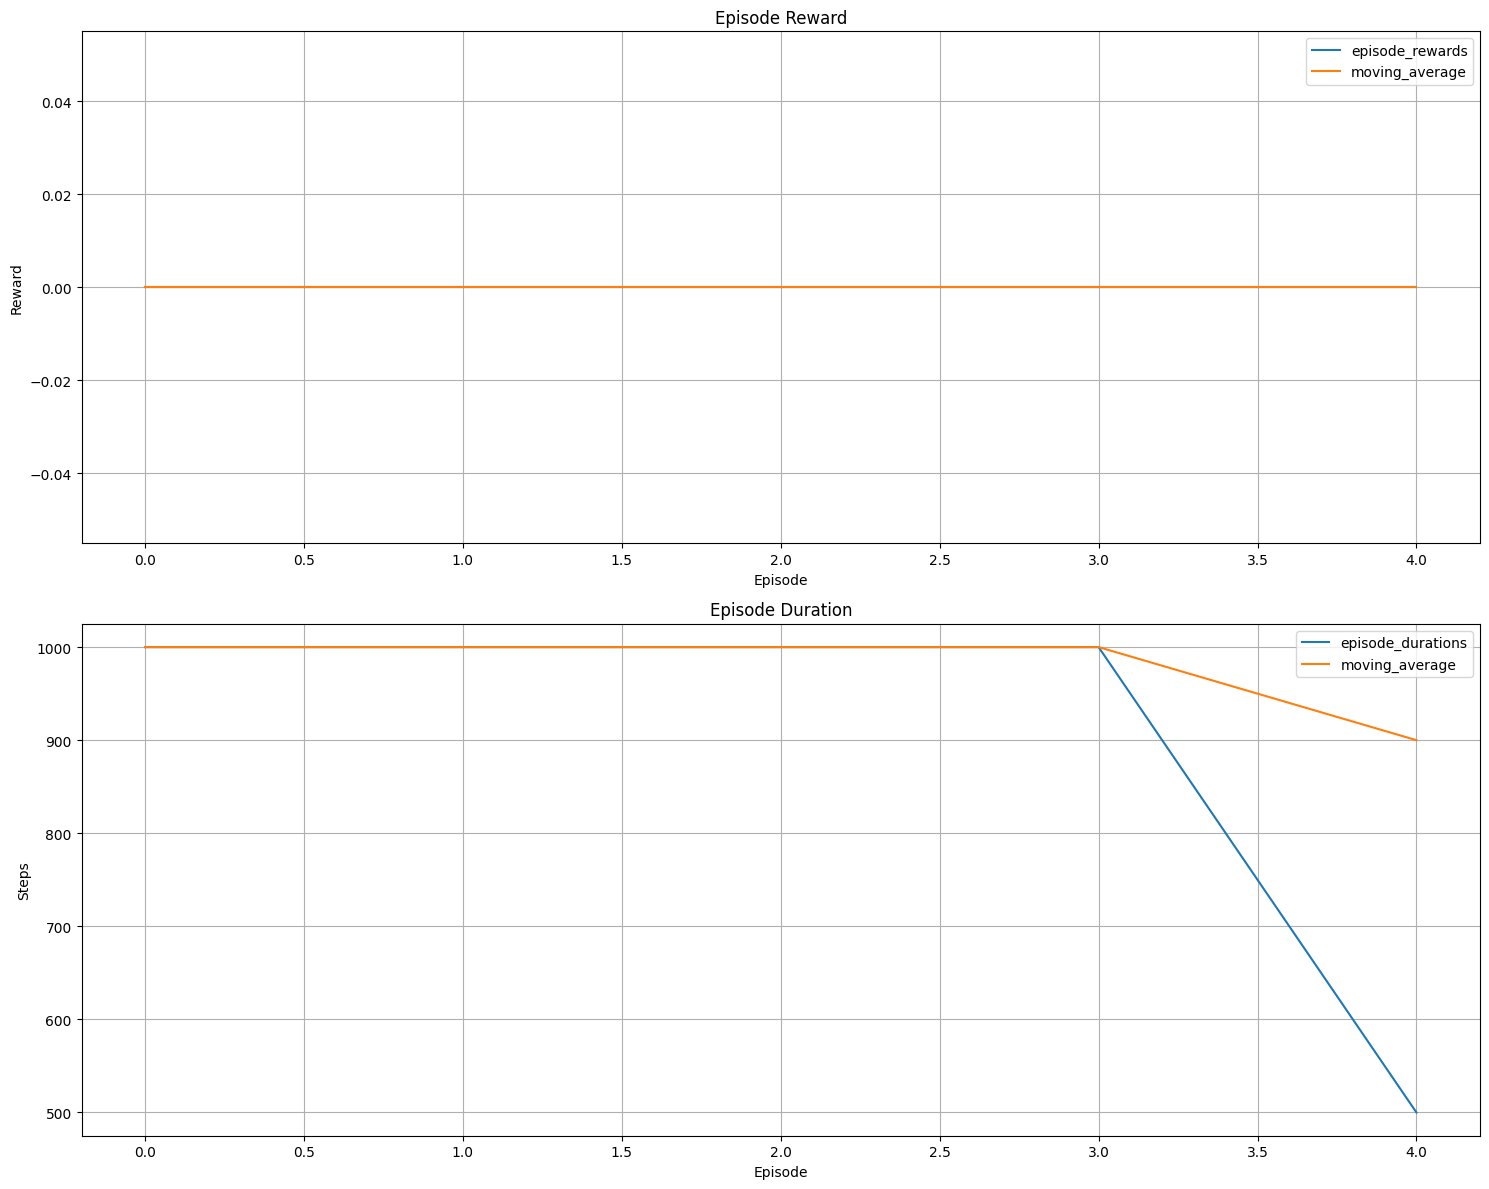

In [47]:
plot_training_metrics(eval_metrics)

### Render

In [ ]:
# Render model (uncomment to see visual results)
ENV_NAME = "MineRLObtainDiamondShovel-v0"
render_model_video("checkpoint_mineRL_DQN_50k/dqn_minerl_log_finder.pt", ENV_NAME, num_episodes=3)

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Recording video to minecraft_recording.mp4
Rendering model predictions...
Episode 1: Reward = 0.0, Steps = 1000
Episode 2: Reward = 0.0, Steps = 1000
Episode 3: Reward = 0.0, Steps = 1000
Video saved to minecraft_recording.mp4
Closing environment...
Environment closed successfully.
